# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply a conditional autoregressive neural spline flow and a conditional masked autoregressive flow to the problem.

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

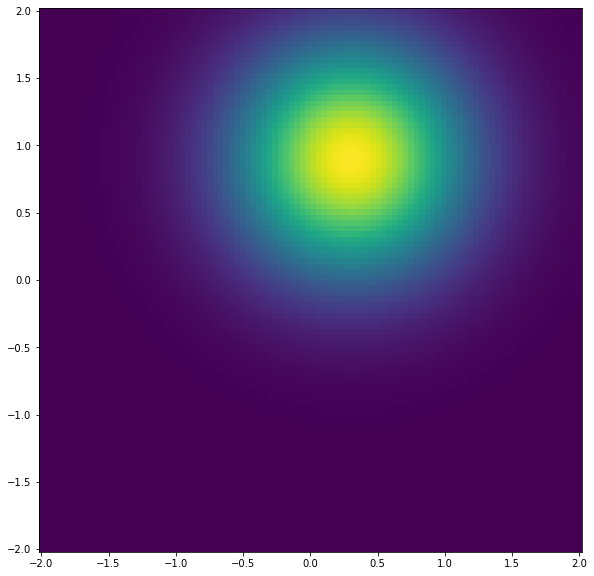

In [3]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 4

# Plot target
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-2, 2, grid_size), torch.linspace(-2, 2, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)
logp = target.log_prob(zz, context_plot)
p_target = torch.exp(logp).view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Autoregressive Neural Spline Flow

### Model specification

In [4]:
# Define flows
K = 4

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

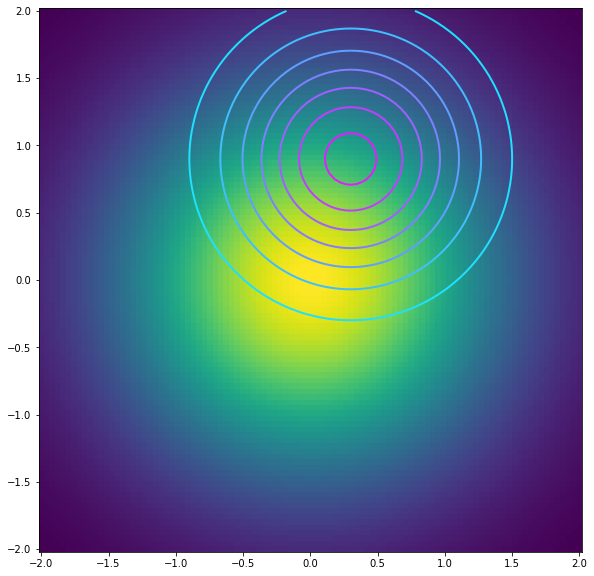

In [5]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Training

100%|████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.66it/s]


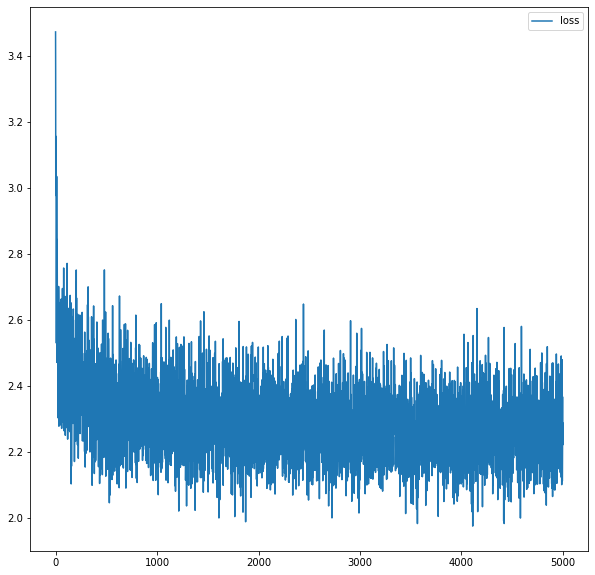

In [6]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device), 
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)], 
                        dim=-1)
    x = target.sample(batch_size, context)
    
    # Compute loss
    loss = model.forward_kld(x, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

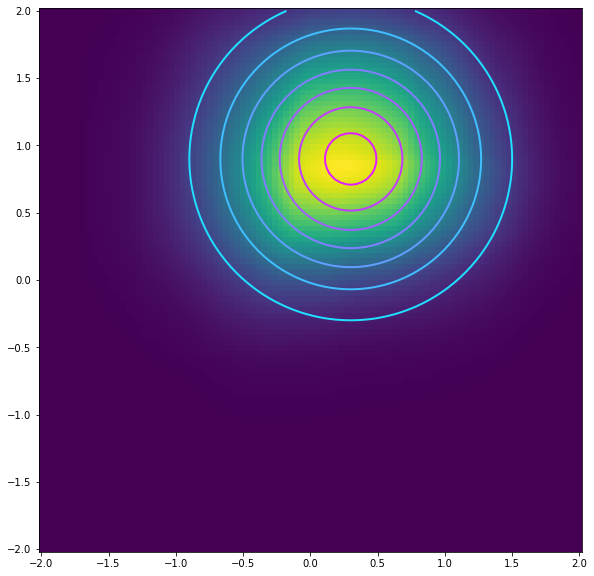

In [7]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

## Masked Autoregressive Flow

### Model specification

In [8]:
# Define flows
K = 4

latent_size = 2
hidden_units = 128
num_blocks = 2

flows = []
for i in range(K):
    flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
                                                  context_features=context_size, 
                                                  num_blocks=num_blocks)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

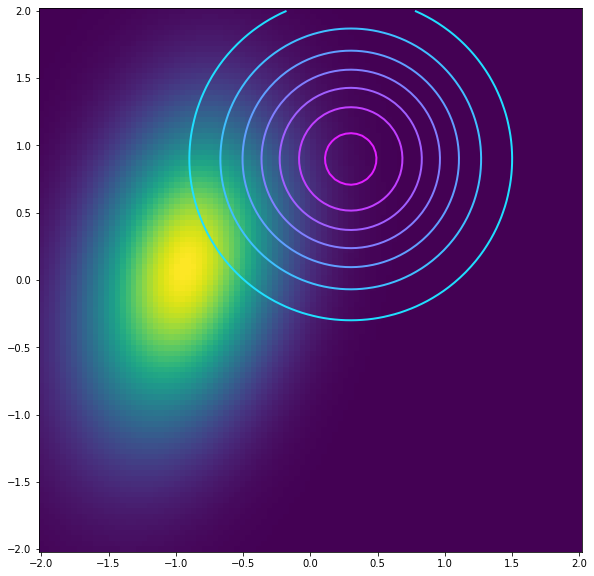

In [9]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Training

100%|████████████████████████████████████████████████████████████| 5000/5000 [01:27<00:00, 56.89it/s]


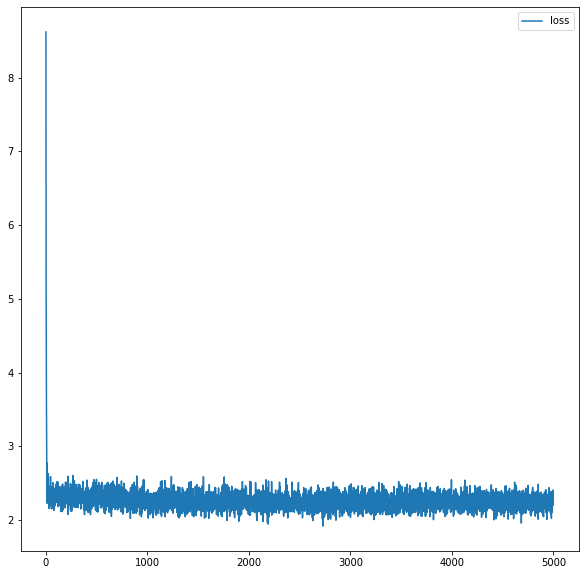

In [10]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device), 
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)], 
                        dim=-1)
    x = target.sample(batch_size, context)
    
    # Compute loss
    loss = model.forward_kld(x, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

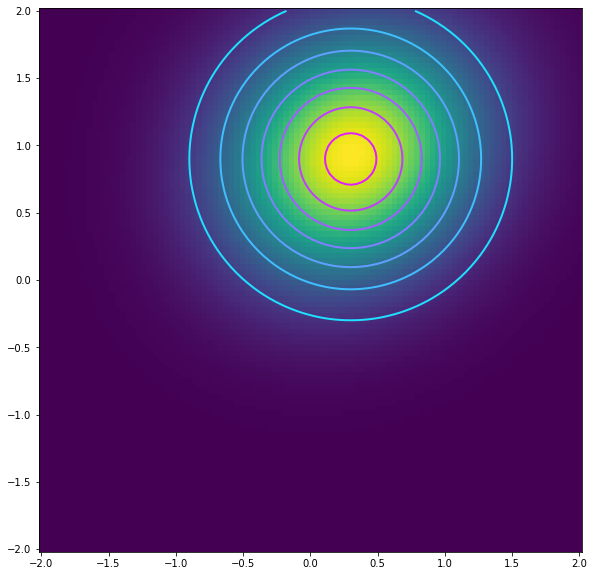

In [11]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()